### Step 1 - Configuration and Setup

In [2]:
# ===============================================================================
# CHINESE-ENGLISH TRANSLATION MODEL - TRAINING FROM SCRATCH
# ===============================================================================
# Configuration and Setup
# ===============================================================================

import os, json, math, time, random
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from datasets import Dataset as HFDataset

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Transformers and Hugging Face
from transformers import (
    Seq2SeqTrainingArguments, Seq2SeqTrainer,
    DataCollatorForSeq2Seq, MarianTokenizer, MarianMTModel, MarianConfig, GenerationConfig,T5Tokenizer
)

# ===============================================================================
# GLOBAL CONFIGURATION
# ===============================================================================

# Device Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Project Paths
MODEL_NAME = "Transformer"
DATA_PATH = Path("../dataset_CN_EN.txt")
RUN_DIR = Path("run")
SPLITS_DIR = RUN_DIR / "data_splits"
OUTPUT_DIR = RUN_DIR / "training_checkpoints"

# Training Configuration
SEED = 42
EPOCHS = 60
BATCH_SIZE = 16
GRAD_ACCUM = 4
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.01
LABEL_SMOOTHING = 0.1
LOG_STEPS = 100

# Data Configuration
MAX_SRC_LENGTH = 128
MAX_TGT_LENGTH = 128
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1

# Model Architecture
MODEL_DIM = 512
NUM_LAYERS = 6
NUM_HEADS = 8
FFN_DIM = 2048
DROPOUT = 0.1

# Create directories
for dir_path in [RUN_DIR, SPLITS_DIR, OUTPUT_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Display configuration
print("CONFIGURATION LOADED")
print(f"Device: {DEVICE}")
print(f"Model: {MODEL_NAME}")
print(f"Training: {EPOCHS} epochs, LR: {LEARNING_RATE}, Batch: {BATCH_SIZE}")
print(f"Architecture: {MODEL_DIM}D, {NUM_LAYERS} layers, {NUM_HEADS} heads")
print("Ready for training from scratch")

CONFIGURATION LOADED
Device: cuda
Model: Transformer
Training: 60 epochs, LR: 0.0003, Batch: 16
Architecture: 512D, 6 layers, 8 heads
Ready for training from scratch


### Step 2 - Data load and Preprocecss

In [3]:
# ===============================================================================
# DATA LOADING AND PREPROCESSING
# ===============================================================================

import re, html, unicodedata

# ===============================================================================
# TEXT NORMALIZATION CONFIGURATION
# ===============================================================================

# Processing flags
LOWERCASE_ENGLISH = True
SIMPLIFY_CHINESE = True
MIN_LENGTH = 2
MAX_LENGTH = 100
RATIO_MIN = 0.5
RATIO_MAX = 3.0
ENABLE_LANGUAGE_CHECK = True

# Text processing patterns
CHINESE_PUNCT_MAP = str.maketrans("，。！？；：（）【】《》""''、—", ",.!?;:()[]<>\"'/-")
URL_PATTERN = re.compile(r"https?://\S+|www\.\S+", re.I)
EMAIL_PATTERN = re.compile(r"\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b", re.I)
CONTROL_CHARS = re.compile(r"[\u0000-\u001F\u007F]")
SPACE_PATTERN = re.compile(r"\s+")

# ===============================================================================
# TEXT PROCESSING FUNCTIONS
# ===============================================================================

def normalize_chinese(text):
    """Normalize Chinese text"""
    text = html.unescape(str(text))
    text = unicodedata.normalize("NFKC", text)
    text = text.translate(CHINESE_PUNCT_MAP)
    text = URL_PATTERN.sub("<URL>", text)
    text = EMAIL_PATTERN.sub("<EMAIL>", text)
    text = CONTROL_CHARS.sub("", text)
    text = SPACE_PATTERN.sub(" ", text).strip()
    return text

def normalize_english(text, lowercase=False):
    """Normalize English text"""
    text = html.unescape(str(text))
    text = unicodedata.normalize("NFKC", text)
    text = URL_PATTERN.sub("<URL>", text)
    text = EMAIL_PATTERN.sub("<EMAIL>", text)
    text = CONTROL_CHARS.sub("", text)
    if lowercase:
        text = text.lower()
    text = SPACE_PATTERN.sub(" ", text).strip()
    return text

def is_chinese_char(char):
    """Check if character is Chinese"""
    code = ord(char)
    return (0x4E00 <= code <= 0x9FFF) or (0x3400 <= code <= 0x4DBF)

def is_english_char(char):
    """Check if character is English"""
    return ('A' <= char <= 'Z') or ('a' <= char <= 'z')

def validate_pair(chinese, english):
    """Validate translation pair quality"""
    if not chinese or not english or chinese == english:
        return False
    
    # Length validation
    cn_len = len(chinese.replace(" ", ""))
    en_len = len(english.split())
    
    if cn_len < MIN_LENGTH or en_len < MIN_LENGTH:
        return False
    if cn_len > MAX_LENGTH or en_len > MAX_LENGTH:
        return False
    
    # Ratio validation
    ratio = en_len / max(cn_len, 1)
    if not (RATIO_MIN <= ratio <= RATIO_MAX):
        return False
    
    # Language validation
    if ENABLE_LANGUAGE_CHECK:
        cn_ratio = sum(is_chinese_char(c) for c in chinese) / max(len(chinese), 1)
        en_ratio = sum(is_english_char(c) for c in english) / max(len(english), 1)
        
        if cn_ratio < 0.6 or en_ratio < 0.6:
            return False
    
    return True

# ===============================================================================
# DATA LOADING AND CLEANING
# ===============================================================================

print("Loading and cleaning data...")

# Load raw data
df_raw = pd.read_csv(DATA_PATH, sep="\t", names=["cn", "en"], header=None, encoding="utf-8")
print(f"Loaded {len(df_raw):,} raw pairs")

# Apply text normalization
df = df_raw.copy()
df["cn_clean"] = df["cn"].map(normalize_chinese)
df["en_clean"] = df["en"].map(lambda x: normalize_english(x, LOWERCASE_ENGLISH))

# Remove duplicates
before_dedup = len(df)
df = df.drop_duplicates(subset=["cn_clean", "en_clean"])
after_dedup = len(df)
print(f"Removed {before_dedup - after_dedup:,} duplicates")

# Quality filtering
valid_mask = [validate_pair(cn, en) for cn, en in zip(df["cn_clean"], df["en_clean"])]
df_filtered = df.loc[valid_mask, ["cn_clean", "en_clean"]]
df_filtered.columns = ["cn", "en"]

print(f"Filtered {len(df) - len(df_filtered):,} low-quality pairs")
print(f"Final dataset: {len(df_filtered):,} clean pairs")

# Save cleaned data
cleaned_path = RUN_DIR / "cleaned_data.tsv"
df_filtered.to_csv(cleaned_path, sep="\t", index=False, encoding="utf-8")
print(f"Saved to: {cleaned_path}")

print("Data preprocessing complete")

Loading and cleaning data...
Loaded 20,289 raw pairs
Removed 4 duplicates
Filtered 2,472 low-quality pairs
Final dataset: 17,813 clean pairs
Saved to: run\cleaned_data.tsv
Data preprocessing complete


### Step 3 - Dataset Splitting


In [4]:
# ===============================================================================
# DATASET SPLITTING
# ===============================================================================

import random

# ===============================================================================
# SPLIT CONFIGURATION
# ===============================================================================

SPLIT_SEED = 42
TRAIN_RATIO = 0.80
VAL_RATIO = 0.10
TEST_RATIO = 0.10

# File paths
train_file = SPLITS_DIR / "train.tsv"
val_file = SPLITS_DIR / "val.tsv"
test_file = SPLITS_DIR / "test.tsv"
metadata_file = SPLITS_DIR / "split_info.json"

# ===============================================================================
# CREATE OR LOAD SPLITS
# ===============================================================================

if all(f.exists() for f in [train_file, val_file, test_file, metadata_file]):
    print("Loading existing data splits...")
    
    train_df = pd.read_csv(train_file, sep="\t", encoding="utf-8")
    val_df = pd.read_csv(val_file, sep="\t", encoding="utf-8")
    test_df = pd.read_csv(test_file, sep="\t", encoding="utf-8")
    
    with open(metadata_file, "r") as f:
        split_info = json.load(f)
    
    print(f"Loaded splits created: {split_info['created_at']}")
    print(f"Using seed: {split_info['split_seed']}")
    
else:
    print("Creating new data splits...")
    
    # Prepare data for splitting
    all_pairs = list(zip(df_filtered["cn"], df_filtered["en"]))
    total_samples = len(all_pairs)
    
    # Create reproducible split indices
    indices = list(range(total_samples))
    random.Random(SPLIT_SEED).shuffle(indices)
    
    # Calculate split sizes
    train_size = int(TRAIN_RATIO * total_samples)
    val_size = int(VAL_RATIO * total_samples)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Create split datasets
    def create_split_data(split_indices):
        cn_data = [all_pairs[i][0] for i in split_indices]
        en_data = [all_pairs[i][1] for i in split_indices]
        return pd.DataFrame({"cn": cn_data, "en": en_data})
    
    train_df = create_split_data(train_indices)
    val_df = create_split_data(val_indices)
    test_df = create_split_data(test_indices)
    
    # Save split files
    train_df.to_csv(train_file, sep="\t", index=False, encoding="utf-8")
    val_df.to_csv(val_file, sep="\t", index=False, encoding="utf-8")
    test_df.to_csv(test_file, sep="\t", index=False, encoding="utf-8")
    
    # Save metadata
    split_info = {
        "split_seed": SPLIT_SEED,
        "train_ratio": TRAIN_RATIO,
        "val_ratio": VAL_RATIO,
        "test_ratio": TEST_RATIO,
        "total_samples": total_samples,
        "train_samples": len(train_indices),
        "val_samples": len(val_indices),
        "test_samples": len(test_indices),
        "created_at": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    
    with open(metadata_file, "w") as f:
        json.dump(split_info, f, indent=2)
    
    print(f"Created new splits with seed {SPLIT_SEED}")

# Display split summary
print(f"DATASET SPLITS")
print(f"Training: {len(train_df):,} pairs ({len(train_df)/len(df_filtered)*100:.1f}%)")
print(f"Validation: {len(val_df):,} pairs ({len(val_df)/len(df_filtered)*100:.1f}%)")
print(f"Testing: {len(test_df):,} pairs ({len(test_df)/len(df_filtered)*100:.1f}%)")

# Create compatibility reference
valid_df = val_df.copy()

print("Dataset splitting complete")

Loading existing data splits...
Loaded splits created: 2025-09-05 00:11:30
Using seed: 42
DATASET SPLITS
Training: 14,231 pairs (79.9%)
Validation: 1,778 pairs (10.0%)
Testing: 1,780 pairs (10.0%)
Dataset splitting complete


### Step 4 - Data Augmentation

In [5]:
# ===============================================================================
# DATA AUGMENTATION
# ===============================================================================

def augment_translation_data(df, aug_factor=0.25):
    """Generate additional training data through simple augmentation"""
    print(f"Applying data augmentation with factor: {aug_factor}")
    
    aug_rows = []
    n_aug = int(len(df) * aug_factor)
    
    for i in range(n_aug):
        idx = np.random.randint(0, len(df))
        cn_text = df.iloc[idx]['cn']
        en_text = df.iloc[idx]['en']
        
        # Simple augmentation techniques
        if np.random.random() > 0.7:
            # Minor punctuation variations for Chinese
            cn_text = cn_text.replace('，', ', ').replace('。', '. ')
            cn_text = re.sub(r'\s+', ' ', cn_text).strip()
        
        if np.random.random() > 0.7:
            # Minor English formatting changes
            en_text = en_text.replace(' ,', ',').replace(' .', '.')
            
        aug_rows.append({'cn': cn_text, 'en': en_text})
    
    aug_df = pd.DataFrame(aug_rows)
    return pd.concat([df, aug_df], ignore_index=True)

# Apply augmentation to training data only
print(f"Before augmentation: {len(train_df):,} samples")
train_df = augment_translation_data(train_df, aug_factor=0.25)
print(f"After augmentation: {len(train_df):,} samples")
print(f"Added {len(train_df) - int(len(train_df)/1.25):,} augmented samples")
print("Data augmentation complete")

Before augmentation: 14,231 samples
Applying data augmentation with factor: 0.25
After augmentation: 17,788 samples
Added 3,558 augmented samples
Data augmentation complete


### Step 5 - BUILD CORPUS + TRAIN SENTENCEPIECE + LOAD & SAVE


In [6]:
# ===============================================================================
# BUILD CORPUS + TRAIN SENTENCEPIECE + LOAD & SAVE
# ===============================================================================

import os, random
from pathlib import Path

# -------------------- CONFIG --------------------
CORPUS_FILE = Path("combined_corpus.txt")   # merged zh+en sentences, one per line
FALLBACK_TSV = Path("cleaned_data.tsv")     
OUT_DIR     = Path("run")
SPM_PREFIX  = "spm"                         # will create run/spm.model and run/spm.vocab
VOCAB_SIZE  = 15000

# Special tokens (IDs must stay consistent across the project)
PAD_ID, BOS_ID, EOS_ID, UNK_ID = 0, 1, 2, 3
PAD_TOK, BOS_TOK, EOS_TOK, UNK_TOK = "<pad>", "<s>", "</s>", "<unk>"

# -------------------- BUILD CORPUS --------------------
def _extract_lines(df, cn_col="cn", en_col="en"):
    lines = []
    if df is not None and cn_col in df.columns:
        lines += [str(x).strip() for x in df[cn_col].tolist() if isinstance(x, str) and x.strip()]
    if df is not None and en_col in df.columns:
        lines += [str(x).strip() for x in df[en_col].tolist() if isinstance(x, str) and x.strip()]
    return lines

if not CORPUS_FILE.exists():
    all_lines = []

    # 1) Try in-memory dataframes
    try:
        import pandas as pd  # for type checks / optional TSV reading
    except ModuleNotFoundError:
        pd = None

    for name in ("train_df", "valid_df", "test_df"):
        df = globals().get(name, None)
        if df is not None:
            lines = _extract_lines(df)
            print(f"[INFO] Collected {len(lines):,} lines from {name}")
            all_lines.extend(lines)

    # 2) Fallback to TSV if no DF lines
    if not all_lines and FALLBACK_TSV.exists():
        if pd is None:
            raise ModuleNotFoundError(
                f"{CORPUS_FILE} missing and need to build from {FALLBACK_TSV}.\n"
                "Install pandas first:\n  pip install pandas"
            )
        df = pd.read_csv(FALLBACK_TSV, sep="\t", encoding="utf-8")
        assert {"cn", "en"}.issubset(df.columns), "cleaned_data.tsv must have 'cn' and 'en' columns"
        lines = _extract_lines(df)
        print(f"[INFO] Collected {len(lines):,} lines from {FALLBACK_TSV}")
        all_lines.extend(lines)

    if not all_lines:
        raise FileNotFoundError(
            f"Corpus not found: {CORPUS_FILE}\n"
            f"Provide train_df/valid_df/test_df with 'cn' and 'en' columns or create {FALLBACK_TSV}."
        )

    # Light cleaning
    all_lines = [ln.replace("\u3000", " ").replace("\t", " ").strip() for ln in all_lines]
    all_lines = [ln for ln in all_lines if 1 < len(ln) <= 512]  # filter extremes

    # Deduplicate (preserve order) + shuffle
    all_lines = list(dict.fromkeys(all_lines))
    random.seed(42); random.shuffle(all_lines)

    CORPUS_FILE.parent.mkdir(parents=True, exist_ok=True)
    with open(CORPUS_FILE, "w", encoding="utf-8") as f:
        for ln in all_lines:
            f.write(ln + "\n")

    print(f"[OK] Wrote {len(all_lines):,} lines to {CORPUS_FILE.resolve()}")
else:
    print(f"[INFO] Using existing corpus at {CORPUS_FILE.resolve()}")

# -------------------- TRAIN SENTENCEPIECE --------------------
try:
    import sentencepiece as spm
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Install sentencepiece first:\n  pip install sentencepiece") from e

OUT_DIR.mkdir(parents=True, exist_ok=True)
model_path = OUT_DIR / SPM_PREFIX

spm.SentencePieceTrainer.Train(
    input=str(CORPUS_FILE),
    model_prefix=str(model_path),
    vocab_size=VOCAB_SIZE,
    model_type="unigram",
    character_coverage=0.9995,    
    input_sentence_size=0,         
    shuffle_input_sentence=True,

    # Explicit special tokens and IDs
    pad_id=PAD_ID, pad_piece=PAD_TOK,
    bos_id=BOS_ID, bos_piece=BOS_TOK,
    eos_id=EOS_ID, eos_piece=EOS_TOK,
    unk_id=UNK_ID, unk_piece=UNK_TOK,
)
print(f"[OK] Trained SentencePiece at {model_path}.model")

# -------------------- LOAD & SAVE TOKENIZER --------------------
try:
    from transformers import T5Tokenizer
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Install transformers first:\n  pip install transformers") from e

tokenizer = T5Tokenizer(
    vocab_file=str(model_path) + ".model",
    pad_token=PAD_TOK,
    bos_token=BOS_TOK,
    eos_token=EOS_TOK,
    unk_token=UNK_TOK,
)

print(f"[INFO] Vocab size: {len(tokenizer)}")
print(f"[INFO] IDs  PAD={tokenizer.pad_token_id}  BOS={tokenizer.bos_token_id}  "
      f"EOS={tokenizer.eos_token_id}  UNK={tokenizer.convert_tokens_to_ids(UNK_TOK)}")

# Quick sanity
print("[TEST] zh ids:", tokenizer("我爱你")["input_ids"][:12])
print("[TEST] en ids:", tokenizer("I love you")["input_ids"][:12])

tokenizer.save_pretrained(str(OUT_DIR))
print(f"[OK] Saved tokenizer to {OUT_DIR.resolve()}")


[INFO] Using existing corpus at D:\combine_AI\nmt\combined_corpus.txt
[OK] Trained SentencePiece at run\spm.model

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



[INFO] Vocab size: 15100
[INFO] IDs  PAD=0  BOS=1  EOS=2  UNK=3
[TEST] zh ids: [13792, 2]
[TEST] en ids: [9, 7054, 238, 11, 2]
[OK] Saved tokenizer to D:\combine_AI\nmt\run


### Step 6 - Tokenizer seteup and preparation

In [7]:
# ===============================================================================
# TOKENIZER SETUP AND DATASET PREPARATION 
# ===============================================================================

from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from datasets import Dataset as HFDataset
import os

# --- paths & lengths ---
TOKENIZER_MODEL_PATH = "run/spm.model"   # produced by the sentencepiece training cell
MAX_SRC_LEN = 128
MAX_TGT_LEN = 128

# --- load tokenizer ---
assert os.path.exists(TOKENIZER_MODEL_PATH), f"Tokenizer model not found: {TOKENIZER_MODEL_PATH}"
tokenizer = T5Tokenizer(
    vocab_file=TOKENIZER_MODEL_PATH,
    pad_token="<pad>",
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
)

# Ensure specials are set
tokenizer.pad_token = "<pad>"
tokenizer.bos_token = "<s>"
tokenizer.eos_token = "</s>"
tokenizer.unk_token = "<unk>"

print("Tokenizer Configuration:")
print(f"   Path: {TOKENIZER_MODEL_PATH}")
print(f"   Vocab size: {len(tokenizer):,}")
print(f"   IDs -> PAD: {tokenizer.pad_token_id}  BOS: {tokenizer.bos_token_id}  EOS: {tokenizer.eos_token_id}  UNK: {tokenizer.convert_tokens_to_ids('<unk>')}")

# --- dataset prep ---
def prepare_dataset(df):
    ds = HFDataset.from_pandas(df)

    def preprocess(batch):
        # Source: Chinese
        model_inputs = tokenizer(
            [str(x) for x in batch["cn"]],
            max_length=MAX_SRC_LEN,
            truncation=True
        )
        # Target: English
        labels = tokenizer(
            text_target=[str(x) for x in batch["en"]],
            max_length=MAX_TGT_LEN,
            truncation=True
        )
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    return ds.map(preprocess, batched=True, remove_columns=ds.column_names)

print("\nCreating tokenized datasets...")
train_dataset = prepare_dataset(train_df)
eval_dataset  = prepare_dataset(valid_df)

print("Dataset Statistics:")
print(f"   Train samples: {len(train_dataset):,}")
print(f"   Validation samples: {len(eval_dataset):,}")
print(f"   Sample keys: {list(train_dataset[0].keys())}")

# Collator: masks label pads to -100 for seq2seq loss
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=None,                
    label_pad_token_id=-100,
    pad_to_multiple_of=8       
)

print("Tokenization complete.")


Tokenizer Configuration:
   Path: run/spm.model
   Vocab size: 15,100
   IDs -> PAD: 0  BOS: 1  EOS: 2  UNK: 3

Creating tokenized datasets...


Map:   0%|          | 0/17788 [00:00<?, ? examples/s]

Map:   0%|          | 0/1778 [00:00<?, ? examples/s]

Dataset Statistics:
   Train samples: 17,788
   Validation samples: 1,778
   Sample keys: ['input_ids', 'attention_mask', 'labels']
Tokenization complete.


### Step 7 - Model Architecture

In [8]:
# =============================================================================== 
# MODEL ARCHITECTURE SETUP
# ===============================================================================

print("Tokenizer special tokens:")
print("  pad_token:", tokenizer.pad_token, tokenizer.pad_token_id)
print("  bos_token:", tokenizer.bos_token, tokenizer.bos_token_id)
print("  eos_token:", tokenizer.eos_token, tokenizer.eos_token_id)

pad_token_id = tokenizer.pad_token_id
bos_token_id = tokenizer.bos_token_id   
eos_token_id = tokenizer.eos_token_id

# Marian generation should start the decoder with PAD 
decoder_start_token_id = pad_token_id

config = MarianConfig(
    vocab_size=len(tokenizer),
    d_model=MODEL_DIM,
    encoder_layers=NUM_LAYERS,
    decoder_layers=NUM_LAYERS,
    encoder_attention_heads=NUM_HEADS,
    decoder_attention_heads=NUM_HEADS,
    encoder_ffn_dim=FFN_DIM,
    decoder_ffn_dim=FFN_DIM,
    dropout=DROPOUT,
    attention_dropout=DROPOUT,
    max_position_embeddings=MAX_SRC_LENGTH,
    pad_token_id=pad_token_id,
    bos_token_id=bos_token_id,
    eos_token_id=eos_token_id,
    decoder_start_token_id=decoder_start_token_id,  # = PAD
    is_encoder_decoder=True,
    tie_word_embeddings=True,
    scale_embedding=True,
)

print("Creating model...")
model = MarianMTModel(config).to(DEVICE)

model.generation_config = GenerationConfig(
    num_beams=5,
    no_repeat_ngram_size=3,
    length_penalty=1.05,
    max_length=128,
    early_stopping=True,
    pad_token_id=pad_token_id,
    eos_token_id=eos_token_id,
)

print(f"Model Configuration:")
print(f"   Architecture: {type(model).__name__}")
print(f"   Device: {next(model.parameters()).device}")
print(f"   Vocabulary size: {model.config.vocab_size:,}")
print("\nToken Configuration:")
print(f"   PAD: {model.config.pad_token_id}")
print(f"   BOS: {model.config.bos_token_id}")
print(f"   EOS: {model.config.eos_token_id}")
print(f"   Decoder start: {model.config.decoder_start_token_id}")


Tokenizer special tokens:
  pad_token: <pad> 0
  bos_token: <s> 1
  eos_token: </s> 2
Creating model...
Model Configuration:
   Architecture: MarianMTModel
   Device: cuda:0
   Vocabulary size: 15,100

Token Configuration:
   PAD: 0
   BOS: 1
   EOS: 2
   Decoder start: 0


### Step 8 - Training Configuration

In [9]:
# ===============================================================================
# TRAINING CONFIGURATION — VERSION-SAFE ARGS + TRAINER (BLEU + chrF only)
# ===============================================================================

import torch, numpy as np, sacrebleu
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, GenerationConfig

# --- metrics: sacreBLEU + chrF (returns 0–100) ---
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 with pad id before decoding references
    if isinstance(labels, np.ndarray):
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    else:
        labels = np.array(labels)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_refs = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # sacreBLEU expects list-of-hypotheses and list-of-reference-lists
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_refs], tokenize="flores101").score
    chrf = sacrebleu.corpus_chrf(decoded_preds, [decoded_refs]).score
    return {"bleu": bleu, "chrf": chrf}

# Ensure the collator knows the model (dynamic padding + label masking)
data_collator.model = model

# --- auto-resume scan ---
print("Checking for existing checkpoints...")
checkpoint_dir = OUTPUT_DIR
resume_checkpoint = None
if checkpoint_dir.exists():
    cpts = [d for d in checkpoint_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
    if cpts:
        latest = sorted(cpts, key=lambda x: int(x.name.split("-")[1]))[-1]
        resume_checkpoint = str(latest)
        print(f"Checkpoint resume: {resume_checkpoint}")
    else:
        print("No checkpoints found")
else:
    print("Output directory doesn't exist - will start fresh training")

# --- build TrainingArguments with only fields version supports ---
fields = getattr(Seq2SeqTrainingArguments, "__dataclass_fields__", {})
has = lambda k: k in fields

args_kwargs = {
    "output_dir": str(OUTPUT_DIR),
    "num_train_epochs": EPOCHS,
    "per_device_train_batch_size": BATCH_SIZE,
    "per_device_eval_batch_size": BATCH_SIZE,
    "gradient_accumulation_steps": GRAD_ACCUM,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "logging_steps": 100,
    "fp16": torch.cuda.is_available(),
    "save_total_limit": 3,
    "remove_unused_columns": False,
    "seed": SEED, "data_seed": SEED,
    "report_to": [],
}

if has("dataloader_pin_memory"):      args_kwargs["dataloader_pin_memory"] = torch.cuda.is_available()
if has("warmup_steps"):               args_kwargs["warmup_steps"] = 500
if has("max_grad_norm"):              args_kwargs["max_grad_norm"] = 1.0
if has("label_smoothing_factor"):     args_kwargs["label_smoothing_factor"] = LABEL_SMOOTHING
if has("predict_with_generate"):      args_kwargs["predict_with_generate"] = True
if has("generation_max_length"):      args_kwargs["generation_max_length"] = MAX_TGT_LENGTH
if has("generation_num_beams"):       args_kwargs["generation_num_beams"] = 5
if has("save_strategy"):              args_kwargs["save_strategy"] = "epoch"
if has("load_best_model_at_end"):     args_kwargs["load_best_model_at_end"] = True
if has("metric_for_best_model"):      args_kwargs["metric_for_best_model"] = "eval_bleu"
if has("greater_is_better"):          args_kwargs["greater_is_better"] = True

eval_key = None
if has("evaluation_strategy"):
    eval_key = "evaluation_strategy"
    args_kwargs[eval_key] = "epoch"
elif has("eval_strategy"):
    eval_key = "eval_strategy"
    args_kwargs[eval_key] = "epoch"
else:
    for k in ("load_best_model_at_end", "metric_for_best_model", "greater_is_better"):
        args_kwargs.pop(k, None)

training_args = Seq2SeqTrainingArguments(**args_kwargs)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

pad_id = tokenizer.pad_token_id
eos_id = tokenizer.eos_token_id
bos_id = getattr(tokenizer, "bos_token_id", None)

# 1) model.config
model.config.pad_token_id = pad_id
model.config.eos_token_id = eos_id
if bos_id is not None:
    model.config.bos_token_id = bos_id
model.config.decoder_start_token_id = pad_id   # Marian-style seq2seq

# 2) model.generation_config
if getattr(model, "generation_config", None) is None:
    model.generation_config = GenerationConfig.from_model_config(model.config)
model.generation_config.pad_token_id = pad_id
model.generation_config.eos_token_id = eos_id
if bos_id is not None:
    model.generation_config.bos_token_id = bos_id
model.generation_config.decoder_start_token_id = pad_id

# 3) pass decoder_start_token_id explicitly during eval generation (version-proof)
if not hasattr(trainer, "_gen_kwargs") or trainer._gen_kwargs is None:
    trainer._gen_kwargs = {}
trainer._gen_kwargs.update({
    "decoder_start_token_id": pad_id,
    "num_beams": 5,
    "max_length": MAX_TGT_LENGTH,
})

print("  Device:", next(model.parameters()).device)
print("  Load best model at end:", getattr(training_args, "load_best_model_at_end", False))
print("  Resume from:", resume_checkpoint or "fresh")


Checking for existing checkpoints...
Checkpoint resume: run\training_checkpoints\checkpoint-11120
  Device: cuda:0
  Load best model at end: True
  Resume from: run\training_checkpoints\checkpoint-11120


C:\Users\USER\AppData\Local\Temp\ipykernel_23384\2643851407.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


### Step 9 - Model Training

In [10]:
# --- SAFETY PATCH: ensure generation has all special IDs before training/eval ---
from transformers import GenerationConfig

pad_id = tokenizer.pad_token_id
eos_id = tokenizer.eos_token_id
bos_id = getattr(tokenizer, "bos_token_id", None)  

# 1) Set on model.config 
model.config.pad_token_id = pad_id
model.config.eos_token_id = eos_id
model.config.bos_token_id = bos_id if bos_id is not None else getattr(model.config, "bos_token_id", None)
model.config.decoder_start_token_id = pad_id   

# 2) create model.generation_config 
if getattr(model, "generation_config", None) is None:
    model.generation_config = GenerationConfig.from_model_config(model.config)

model.generation_config.pad_token_id = pad_id
model.generation_config.eos_token_id = eos_id
model.generation_config.bos_token_id = bos_id if bos_id is not None else getattr(model.generation_config, "bos_token_id", None)
model.generation_config.decoder_start_token_id = pad_id

# 3) Tell Seq2SeqTrainer to pass decoder_start_token_id to generate()
#    This covers older transformers that ignore model.generation_config during eval.
if not hasattr(trainer, "_gen_kwargs") or trainer._gen_kwargs is None:
    trainer._gen_kwargs = {}
trainer._gen_kwargs.update({
    "decoder_start_token_id": pad_id,
    "max_length": MAX_TGT_LEN,
    "num_beams": 5,
})

# Quick sanity print
print("[gen IDs] pad:", model.config.pad_token_id,
      "eos:", model.config.eos_token_id,
      "bos:", model.config.bos_token_id,
      "dec_start:", model.config.decoder_start_token_id)


[gen IDs] pad: 0 eos: 2 bos: 1 dec_start: 0


In [11]:
# ===============================================================================
# MODEL TRAINING EXECUTION 
# ===============================================================================

from pathlib import Path

epochs = getattr(training_args, "num_train_epochs", 0) or 0
max_steps = getattr(training_args, "max_steps", None)
if epochs <= 0 and (max_steps is None or max_steps == 0):
    raise ValueError("No train epoch added")

if len(train_dataset) == 0:
    raise ValueError("No dataset")

eval_strat = getattr(training_args, "evaluation_strategy", getattr(training_args, "eval_strategy", "no")).lower()
if getattr(training_args, "load_best_model_at_end", False) and eval_strat in ("no", "none", "", None):
    print("[WARN] load_best_model_at_end=True but no evaluation strategy available on this version.")
    print("       Disabling best-at-end to avoid saving an unintended checkpoint.")
    training_args.load_best_model_at_end = False

# --- Resume or fresh
resume_arg = resume_checkpoint  
print("Starting training...")
print("  Output dir:", training_args.output_dir)
print("  Epochs    :", epochs if epochs else f"steps-based: {max_steps}")
print("  Device    :", next(model.parameters()).device)
print("  Resume    :", resume_arg or "fresh")

# --- Train
try:
    trainer.train(resume_from_checkpoint=resume_arg)
    print("Training completed.")
except Exception as e:
    print(f"Training failed: {e}")
    raise

# --- Post-train checks and save ONLY if steps > 0
global_step = int(getattr(trainer.state, "global_step", 0) or 0)
best_ckpt   = getattr(trainer.state, "best_model_checkpoint", None)

print("global_step:", global_step)
print("best_model_checkpoint:", best_ckpt)

if global_step <= 0:
    print("[SKIP SAVE] No training steps ran. Not saving a model to avoid an untrained snapshot.")
else:
    tag = "best_model" if getattr(training_args, "load_best_model_at_end", False) else "final_model"
    save_dir = RUN_DIR / tag
    print(f"Saving {tag} to: {save_dir}")

    trainer.save_model(str(save_dir))        # weights + config
    tokenizer.save_pretrained(str(save_dir)) # saves spm.model for T5Tokenizer
    try:
        model.generation_config.save_pretrained(str(save_dir))
    except Exception:
        pass

    if getattr(training_args, "load_best_model_at_end", False) and not best_ckpt:
        print("[NOTE] best-at-end was requested, but no best checkpoint recorded. "
              "This usually means eval/save strategies didn’t run; saved final weights instead.")


import warnings
warnings.filterwarnings("ignore", message="Tokenizer 'spm' has been changed to 'flores101'")

Starting training...
  Output dir: run\training_checkpoints
  Epochs    : 60
  Device    : cuda:0
  Resume    : run\training_checkpoints\checkpoint-11120


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Bleu,Chrf
41,1.333200,3.629344,28.549076,44.252488
42,1.349200,3.607749,29.313872,44.588389
43,1.334600,3.639373,29.822413,45.012517
44,1.328400,3.630025,29.301066,44.617480
45,1.325700,3.631939,29.949154,45.312228
46,1.321900,3.635418,29.903531,45.271681
47,1.320400,3.643566,29.923923,45.219929
48,1.318400,3.656934,30.206730,45.545195
49,1.318300,3.647048,29.600252,45.145540
50,1.316600,3.645771,30.024954,45.427423


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


Training completed.
global_step: 16680
best_model_checkpoint: run\training_checkpoints\checkpoint-6672
Saving best_model to: run\best_model


### Step 10 - Model Evaluation

In [12]:
# ===============================================================================
# Model Evaluation
# ===============================================================================

import os, torch, sacrebleu
from pathlib import Path

assert 'model' in globals() and 'tokenizer' in globals(), "Load your model & tokenizer first."
assert 'test_df' in globals(), "Provide a test_df with columns: 'cn' (src), 'en' (ref)."

# --- safety: make sure generation has required special IDs
pad_id = tokenizer.pad_token_id
eos_id = tokenizer.eos_token_id
if getattr(model.config, "decoder_start_token_id", None) is None:
    model.config.decoder_start_token_id = pad_id
if getattr(model, "generation_config", None) is not None:
    model.generation_config.pad_token_id = pad_id
    model.generation_config.eos_token_id = eos_id
    model.generation_config.decoder_start_token_id = pad_id

# --- collect inputs
src_texts = [str(x).strip() for x in test_df["cn"].tolist() if isinstance(x, str) and x.strip()]
refs      = [test_df["en"].astype(str).tolist()]  # sacrebleu expects list-of-lists
print(f"[EVAL] Generating for {len(src_texts)} test samples...")

# --- batched generation
BATCH_SIZE = 16
NUM_BEAMS  = 5  # use 1 for speed; use 5 for report
preds = []

model.eval()
with torch.inference_mode():
    for i in range(0, len(src_texts), BATCH_SIZE):
        batch_src = src_texts[i:i+BATCH_SIZE]
        enc = tokenizer(
            batch_src,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_SRC_LEN
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}
        gen_ids = model.generate(
            **enc,
            num_beams=NUM_BEAMS,
            max_length=MAX_TGT_LEN,
            decoder_start_token_id=pad_id  # version-proof
        )
        preds.extend(tokenizer.batch_decode(gen_ids, skip_special_tokens=True))

# --- save predictions
out_dir = Path(RUN_DIR) / "eval"
out_dir.mkdir(parents=True, exist_ok=True)
out_csv = out_dir / "test_predictions.csv"
test_out = test_df.copy()
test_out["predicted_en"] = preds[:len(test_out)]
test_out.to_csv(out_csv, index=False)
print(f"[EVAL] Saved predictions to: {out_csv}")

# --- metrics: sacreBLEU + chrF++
bleu = sacrebleu.corpus_bleu(preds, refs, tokenize="spm").score
chrf = sacrebleu.corpus_chrf(preds, refs).score  # chrF++

print(f"\n=== MT Metrics ===")
print(f"BLEU    : {bleu:.2f}")
print(f"chrF++   : {chrf:.2f}")

warnings.filterwarnings("ignore", message="Tokenizer 'spm' has been changed to 'flores101'")

[EVAL] Generating for 1780 test samples...


Tokenizer 'spm' has been changed to 'flores101', and may be removed in the future.


[EVAL] Saved predictions to: run\eval\test_predictions.csv

=== MT Metrics ===
BLEU    : 29.08
chrF++   : 45.08


### Step 11 - Training Metics Analysis

In [13]:
# ===============================================================================
# TRAINING METRICS ANALYSIS (BLEU + chrF only)
# ===============================================================================

import json, pandas as pd, numpy as np
from pathlib import Path

print("Analyzing training metrics...")

checkpoint_dir = OUTPUT_DIR  
state_file = None
latest_checkpoint = None

if checkpoint_dir.exists():
    checkpoints = [d for d in checkpoint_dir.iterdir()
                   if d.is_dir() and d.name.startswith("checkpoint-")]
    if checkpoints:
        checkpoints = sorted(checkpoints, key=lambda x: int(x.name.split("-")[1]))
        latest_checkpoint = checkpoints[-1]
        state_file = latest_checkpoint / "trainer_state.json"

print(f"Looking for state file in: {state_file}")
print(f"State file exists: {state_file.exists() if state_file else False}")

if state_file and state_file.exists():
    with open(state_file, "r", encoding="utf-8") as f:
        trainer_state = json.load(f)

    log_history = trainer_state.get("log_history", [])
    train_metrics = [e for e in log_history if "train_loss" in e]
    eval_metrics  = [e for e in log_history if "eval_loss" in e]

    print(f"Found {len(train_metrics)} training log entries")
    print(f"Found {len(eval_metrics)} evaluation log entries")

    if train_metrics or eval_metrics:
        rows = []
        for e in train_metrics:
            rows.append({
                "step": e.get("step", 0),
                "epoch": e.get("epoch", 0),
                "train_loss": e.get("train_loss"),
                "learning_rate": e.get("learning_rate"),
                "type": "train",
            })
        for e in eval_metrics:
            rows.append({
                "step": e.get("step", 0),
                "epoch": e.get("epoch", 0),
                "eval_loss": e.get("eval_loss"),
                "eval_bleu": e.get("eval_bleu"),
                "eval_chrf": e.get("eval_chrf"),
                "type": "eval",
            })

        metrics_df = pd.DataFrame(rows)
        metrics_path = RUN_DIR / "eval" / "training_metrics.csv"
        metrics_path.parent.mkdir(parents=True, exist_ok=True)
        metrics_df.to_csv(metrics_path, index=False)
        print(f"Training metrics saved to: {metrics_path}")

        if train_metrics:
            final_train_loss = train_metrics[-1]["train_loss"]
            print(f"\nFinal training loss: {final_train_loss:.4f}")
        if eval_metrics:
            final_eval_loss = eval_metrics[-1]["eval_loss"]
            print(f"Final validation loss: {final_eval_loss:.4f}")
            if eval_metrics[-1].get("eval_bleu") is not None:
                final_bleu = eval_metrics[-1]["eval_bleu"]
                print(f"Final BLEU: {final_bleu:.2f}")
            if eval_metrics[-1].get("eval_chrf") is not None:
                final_chrf = eval_metrics[-1]["eval_chrf"]
                print(f"Final chrF++: {final_chrf:.2f}")
    else:
        print("No training metrics found in log_history.")
else:
    print("No trainer state file found.")
    if latest_checkpoint:
        print(f"Checked in: {latest_checkpoint}")

# Save compact model info 
model_info = {
    "model_type": "Custom Marian MT",
    "vocab_size": len(tokenizer),
    "model_parameters": int(sum(p.numel() for p in model.parameters())),
    "trainable_parameters": int(sum(p.numel() for p in model.parameters() if p.requires_grad)),
    "training_config": {
        "epochs": float(getattr(training_args, "num_train_epochs", 0)),
        "batch_size": int(getattr(training_args, "per_device_train_batch_size", 0)),
        "learning_rate": float(getattr(training_args, "learning_rate", 0.0)),
        "weight_decay": float(getattr(training_args, "weight_decay", 0.0)),
    },
    "dataset_info": {
        "train_samples": len(train_dataset),
        "eval_samples": len(eval_dataset),
        "test_samples": len(test_df),
    },
}
info_path = RUN_DIR / "eval" / "model_info.json"
with open(info_path, "w", encoding="utf-8") as f:
    json.dump(model_info, f, indent=2, ensure_ascii=False)
print(f"Model information saved to: {info_path}")
print("Training metrics analysis complete.")


Analyzing training metrics...
Looking for state file in: run\training_checkpoints\checkpoint-16680\trainer_state.json
State file exists: True
Found 0 training log entries
Found 60 evaluation log entries
Training metrics saved to: run\eval\training_metrics.csv
Final validation loss: 3.6812
Final BLEU: 30.28
Final chrF++: 45.46
Model information saved to: run\eval\model_info.json
Training metrics analysis complete.


In [ ]:
# ===============================================================================
# EXTRA METRICS: Accuracy, Precision, Recall, F1
# ===============================================================================

import re, math
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd

# --- Load predictions ---
pred_path = RUN_DIR / "eval" / "test_predictions.csv"
if "test_preds_df" in globals():
    df = test_preds_df.copy()
elif pred_path.exists():
    df = pd.read_csv(pred_path)
else:
    raise FileNotFoundError(
        f"Predictions not found.\nExpected either a `test_preds_df` variable "
        f"or a file at {pred_path}. Run decoding first to create it."
    )

# --- Basic checks ---
for col in ("en", "predicted_en"):
    if col not in df.columns:
        raise KeyError(f"Missing column '{col}' in predictions DataFrame.")

_punct_re = re.compile(r"[^\w\s']+", flags=re.UNICODE)   

def normalize_text(s: str) -> str:
    s = str(s).strip().lower()
    s = _punct_re.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize_words(s: str):
    return normalize_text(s).split()

# --- Compute metrics ---
N = len(df)
exact_matches = 0
tok_correct = 0
tok_total = 0

TP = 0  # true positives (bag-of-words overlap count)
FP = 0  # false positives
FN = 0  # false negatives

for _, row in df.iterrows():
    ref = str(row["en"])
    hyp = str(row["predicted_en"])

    ref_norm = normalize_text(ref)
    hyp_norm = normalize_text(hyp)

    # 1) Sentence-level exact match (after normalization)
    if hyp_norm == ref_norm:
        exact_matches += 1

    # 2) Position-aware token accuracy (aligned by position, up to min length)
    ref_toks = ref_norm.split()
    hyp_toks = hyp_norm.split()
    m = min(len(ref_toks), len(hyp_toks))
    tok_correct += sum(1 for i in range(m) if hyp_toks[i] == ref_toks[i])
    tok_total   += len(ref_toks)  # denominator = reference length

    # 3) Bag-of-words P/R/F1 (order-agnostic)
    c_ref = Counter(ref_toks)
    c_hyp = Counter(hyp_toks)
    tp_pair = sum((c_ref & c_hyp).values())
    fp_pair = sum(c_hyp.values()) - tp_pair
    fn_pair = sum(c_ref.values()) - tp_pair
    TP += tp_pair; FP += fp_pair; FN += fn_pair

# --- Aggregate ---
sent_exact_acc = exact_matches / N if N else 0.0
token_acc      = tok_correct / tok_total if tok_total else 0.0

prec = TP / (TP + FP) if (TP + FP) else 0.0
rec  = TP / (TP + FN) if (TP + FN) else 0.0
f1   = (2 * prec * rec / (prec + rec)) if (prec + rec) else 0.0

print("=== EXTRA METRICS (normalized, whitespace-tokenized) ===")
print(f"Sentence Exact Accuracy : {sent_exact_acc*100:6.2f}%")
print(f"Token Accuracy (posn)   : {token_acc*100:6.2f}%")
print(f"Precision (BoW)         : {prec*100:6.2f}%")
print(f"Recall (BoW)            : {rec*100:6.2f}%")
print(f"F1 (BoW)                : {f1*100:6.2f}%")

# save a small metrics JSON/CSV
metrics_out = RUN_DIR / "eval" / "extra_metrics.csv"
metrics_out.parent.mkdir(parents=True, exist_ok=True)
pd.DataFrame([{
    "sentence_exact_acc": sent_exact_acc,
    "token_acc_positional": token_acc,
    "precision_bow": prec,
    "recall_bow": rec,
    "f1_bow": f1,
    "num_samples": int(N)
}]).to_csv(metrics_out, index=False)
print(f"\nSaved: {metrics_out}")


=== EXTRA METRICS (normalized, whitespace-tokenized) ===
Sentence Exact Accuracy :   7.92%
Token Accuracy (posn)   :  34.28%
Precision (BoW)         :  52.30%
Recall (BoW)            :  51.34%
F1 (BoW)                :  51.81%

Saved: run\eval\extra_metrics.csv


### Step 12 - Visualization

Looking for metrics file at: run\eval\training_metrics.csv
Metrics file loaded.


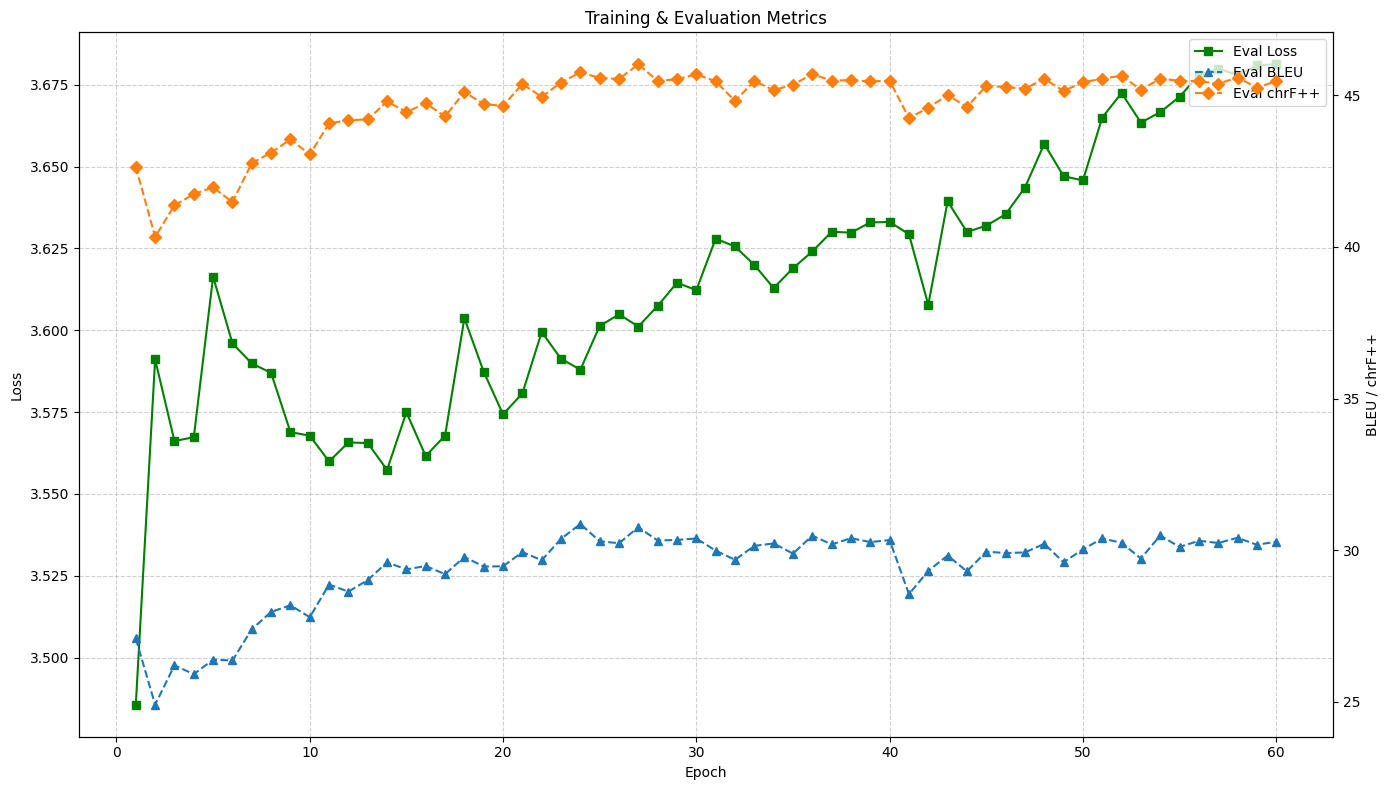

In [14]:
# ===============================================================================
# TRAINING METRICS VISUALIZATION (Loss + BLEU + chrF)
# ===============================================================================

import pandas as pd
import matplotlib.pyplot as plt

metrics_path = RUN_DIR / "eval" / "training_metrics.csv"
print(f"Looking for metrics file at: {metrics_path}")

if metrics_path.exists():
    metrics_df = pd.read_csv(metrics_path)
    print("Metrics file loaded.")

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Left axis: losses
    if "train_loss" in metrics_df.columns:
        tr = metrics_df[metrics_df["type"] == "train"]
        ax1.plot(tr["epoch"], tr["train_loss"], label="Train Loss", marker="o")
    if "eval_loss" in metrics_df.columns:
        ev = metrics_df[metrics_df["type"] == "eval"]
        ax1.plot(ev["epoch"], ev["eval_loss"], label="Eval Loss", marker="s", color="green")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, linestyle="--", alpha=0.6)

    ax2 = ax1.twinx()
    if "eval_bleu" in metrics_df.columns and metrics_df["eval_bleu"].notnull().any():
        ev = metrics_df[metrics_df["type"] == "eval"]
        ax2.plot(ev["epoch"], ev["eval_bleu"], label="Eval BLEU", marker="^", linestyle="--")
    if "eval_chrf" in metrics_df.columns and metrics_df["eval_chrf"].notnull().any():
        ev = metrics_df[metrics_df["type"] == "eval"]
        ax2.plot(ev["epoch"], ev["eval_chrf"], label="Eval chrF++", marker="D", linestyle="--")
    ax2.set_ylabel("BLEU / chrF++")

    # Merge legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper right")
    plt.title("Training & Evaluation Metrics")
    plt.tight_layout()
    plt.show()
else:
    print(f"No metrics file found at {metrics_path}. Run the analysis cell after training.")


### Step 13 - Interactive Translation Testing

In [15]:
# ===============================================================================
# INTERACTIVE TRANSLATION
# ===============================================================================

# Safety: make sure generate() has what it needs on all versions
pad_id = tokenizer.pad_token_id
eos_id = tokenizer.eos_token_id
if getattr(model.config, "decoder_start_token_id", None) is None:
    model.config.decoder_start_token_id = pad_id

def translate_text(x, max_length=MAX_TGT_LENGTH, beams=5):

    if isinstance(x, str):
        texts = [x.strip()]
    else:
        texts = [str(t).strip() for t in x]

    # filter empties
    clean = [t for t in texts if t]
    if not clean:
        return "" if isinstance(x, str) else []

    enc = tokenizer(
        clean,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SRC_LENGTH,
    )
    enc = {k: v.to(model.device) for k, v in enc.items()}

    model.eval()
    with torch.no_grad():
        gen_ids = model.generate(
            **enc,
            num_beams=beams,                 
            max_length=max_length,
            decoder_start_token_id=pad_id,
            pad_token_id=pad_id,
            eos_token_id=eos_id,
            do_sample=False,                 # deterministic beam search
        )

    outs = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
    return outs[0] if isinstance(x, str) else outs

# --- quick smoke test ---
_examples = ["你好世界", "我爱你", "今天天气很好", "我们去吃饭吧", "我喜欢学习英文", "谢谢你的帮助"]
for i, cn in enumerate(_examples, 1):
    print(f"Example {i}: {cn} -> {translate_text(cn)}")


Example 1: 你好世界 -> you're a good world.
Example 2: 我爱你 -> i love you more than you.
Example 3: 今天天气很好 -> today, the weather is very nice.
Example 4: 我们去吃饭吧 -> let's eat to eat.
Example 5: 我喜欢学习英文 -> i like english.
Example 6: 谢谢你的帮助 -> thank you for your help.


In [20]:
from IPython.display import display, HTML

if num_matches > 0:
    print("\nExamples of exact matches:")
    html = df[matches][["cn", "en", "predicted_en"]].reset_index(drop=True).to_html(
        max_rows=1000,  # show up to 1000 rows
        escape=False
    )
    display(HTML(f'<div style="max-height:400px; overflow:auto">{html}</div>'))
else:
    print("No exact matches found.")


Examples of exact matches:


,cn,en,predicted_en
0,它属于我兄弟.,it belongs to my brother.,it belongs to my brother.
1,你有多少张CD?,how many cds do you have?,how many cds do you have?
2,我不能喝牛奶.,i can't drink milk.,i can't drink milk.
3,他感冒了.,he caught a cold.,he caught a cold.
4,这是一朵美丽的花.,this is a beautiful flower.,this is a beautiful flower.
5,那时她正在洗碗.,she was washing the dishes.,she was washing the dishes.
6,我昨天买了这台相机.,i bought this camera yesterday.,i bought this camera yesterday.
7,我不是医生.,i'm not a doctor.,i'm not a doctor.
8,玛丽昨晚熬夜.,mary stayed up late last night.,mary stayed up late last night.
9,我真喜欢这故事.,i really like this story.,i really like this story.
